In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install SimpleITK

     |████████████████████████████████| 48.4 MB 32 kB/s 


In [4]:
import SimpleITK as sitk
import numpy as np
import pandas as pd
import tensorflow
import matplotlib.pyplot as plt
import seaborn as sns 

import os
import glob
import scipy.misc
import cv2

##import SimpleITK as sitk

from PIL import Image

#from scipy.misc import imread

%matplotlib inline
from IPython.display import clear_output
pd.options.mode.chained_assignment = None

In [5]:
annotations = pd.read_csv('/content/drive/My Drive/Dataset_LUNA_16/annotations.csv')
candidates = pd.read_csv('/content/drive/My Drive/Dataset_LUNA_16/candidates.csv')

In [6]:
annotations.head()

seriesuid  ...  diameter_mm
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...     5.651471
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...     4.224708
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...  ...     5.786348
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  ...     8.143262
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  ...    18.545150

[5 rows x 5 columns]

In [7]:
candidates['class'].sum()

1351

In [8]:
print(len(candidates[candidates['class'] == 1]))
print(len(candidates[candidates['class'] == 0]))

1351
549714


In [9]:
import multiprocessing
num_cores = multiprocessing.cpu_count()
print(num_cores)

2


In [10]:
malignantCand = candidates[candidates['class']==1].index  
benignCand = candidates[candidates['class']==0].index

In [11]:
benignCand

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            551055, 551056, 551057, 551058, 551059, 551060, 551061, 551062,
            551063, 551064],
           dtype='int64', length=549714)

In [12]:
malignantCand

Int64Index([    13,     78,   1303,   3050,   3052,   3080,   3223,   3285,
              3287,   3289,
            ...
            545928, 546205, 546372, 546400, 547498, 548674, 550171, 550334,
            550810, 550906],
           dtype='int64', length=1351)

In [13]:
np.random.seed(42)
benignIndexes = np.random.choice(benignCand, len(malignantCand)*5, replace = False)

In [14]:
candidatesDf = candidates.iloc[list(malignantCand)+list(benignIndexes)]

In [15]:
from sklearn.model_selection import train_test_split
X = candidatesDf.iloc[:,:-1]
y = candidatesDf.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.30, random_state = 42)

In [17]:
print('number of positive cases are ' + str(y_train.sum()))
print('total set size is ' + str(len(y_train)))
print('percentage of positive cases are ' + str(y_train.sum()*1.0/len(y_train)))

number of positive cases are 628
total set size is 3971
percentage of positive cases are 0.15814656257869555


In [18]:
tempDf = X_train[y_train == 1]
tempDf = tempDf.set_index(X_train[y_train == 1].index + 1000000)
X_train_new = X_train.append(tempDf)
tempDf = tempDf.set_index(X_train[y_train == 1].index + 2000000)
X_train_new = X_train_new.append(tempDf)

ytemp = y_train.reindex(X_train[y_train == 1].index + 1000000)
ytemp.loc[:] = 1
y_train_new = y_train.append(ytemp)
ytemp = y_train.reindex(X_train[y_train == 1].index + 2000000)
ytemp.loc[:] = 1
y_train_new = y_train_new.append(ytemp)

print(len(X_train_new), len(y_train_new))

5227 5227


In [19]:
train_filenames =\
X_train_new.index.to_series().apply(lambda x:\
                                    '/content/drive/My Drive/Dataset_LUNA_16/data/train/image_'+str(x)+'.jpg')
train_filenames.values.astype(str)

array(['/content/drive/My Drive/Dataset_LUNA_16/data/train/image_269021.jpg',
       '/content/drive/My Drive/Dataset_LUNA_16/data/train/image_124471.jpg',
       '/content/drive/My Drive/Dataset_LUNA_16/data/train/image_333859.jpg',
       ...,
       '/content/drive/My Drive/Dataset_LUNA_16/data/train/image_2403172.jpg',
       '/content/drive/My Drive/Dataset_LUNA_16/data/train/image_2473694.jpg',
       '/content/drive/My Drive/Dataset_LUNA_16/data/train/image_2372119.jpg'],
      dtype='<U68')

In [20]:
dataset_file = 'traindatalabels.txt'
filenames = train_filenames.values.astype(str)
train_filenames =X_train_new.index.to_series().apply(lambda x:filenames)
labels = y_train_new.values.astype(int)
traindata = np.zeros(filenames.size,\
                     dtype=[('var1', 'S36'), ('var2', int)])
traindata['var1'] = filenames
traindata['var2'] = labels

np.savetxt(dataset_file, traindata, fmt="%10s %d")

In [21]:
!pip install tflearn 

     |████████████████████████████████| 107 kB 4.1 MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127299 sha256=9e7d448ab6c66d0cce89b90885e6e5fb25e46520c211c7fe5da35529ebe03b6b
  Stored in directory: /root/.cache/pip/wheels/5f/14/2e/1d8e28cc47a5a931a2fb82438c9e37ef9246cc6a3774520271
Successfully built tflearn


In [22]:
import tflearn
from tflearn.data_utils import build_hdf5_image_dataset

Instructions for updating:
non-resource variables are not supported in the long term


In [23]:
dataset_file

'traindatalabels.txt'

In [24]:
# build_hdf5_image_dataset(dataset_file, image_shape=(50, 50), mode='file', output_path='traindataset.h5', categorical_labels=True, normalize=True)

In [25]:
# Load HDF5 dataset
import h5py
h5f = h5py.File('/content/drive/My Drive/Dataset_LUNA_16/data/traindataset.h5', 'r')
X_train_images = h5f['X']
Y_train_labels = h5f['Y']

h5f2 = h5py.File('/content/drive/My Drive/Dataset_LUNA_16/data/valdataset.h5', 'r')
X_val_images = h5f2['X']
Y_val_labels = h5f2['Y']

In [26]:
X_train_images

<HDF5 dataset "X": shape (5187, 50, 50), type "<f4">

In [27]:
Y_train_labels

<HDF5 dataset "Y": shape (5187, 2), type "<f4">

In [28]:
X_val_images

<HDF5 dataset "X": shape (1297, 50, 50), type "<f4">

In [29]:
Y_val_labels

<HDF5 dataset "Y": shape (1297, 2), type "<f4">

In [30]:
X_train_processing = np.array(X_train_images)
X_val_processing = np.array(X_val_images)

In [31]:
print(X_train_processing.shape)
print(X_val_processing.shape)

(5187, 50, 50)
(1297, 50, 50)


In [32]:
print(X_train_processing.dtype)
print(X_val_processing.dtype)

float32
float32


In [33]:
#from scipy.misc import imresize
from PIL import ImageEnhance

class PreProcessing(object):
    def __init__(self, image = None):
        self.image = image
    
    def subtract_mean(self):
        self.image = (self.image/255.0 - 0.25)*255
        return self.image
    
    def downsample_data(self):
        self.image = cv2.resize(self.image, (40,40), interpolation = cv2.INTER_AREA)
        return self.image

    def upsample_data(self):
        self.image = cv2.resize(self.image, (224, 224), interpolation = cv2.INTER_CUBIC)
        return self.image

In [34]:
img_test = X_train_processing[100]
img_test_downsampled = PreProcessing(img_test).downsample_data()
img_test_upsampled = PreProcessing(img_test).upsample_data()

In [35]:
print(Y_train_labels[100])

[1. 0.]


In [36]:
X_train_images_np = np.expand_dims(np.array(X_train_images), axis = 3)
y_train_labels_np = np.array(Y_train_labels)
X_val_images_np = np.expand_dims(np.array(X_val_images), axis = 3)
y_val_labels_np = np.array(Y_val_labels)

In [37]:
print(X_train_images_np.shape)
print(y_train_labels_np.shape)
print(X_val_images_np.shape)
print(y_val_labels_np.shape)

(5187, 50, 50, 1)
(5187, 2)
(1297, 50, 50, 1)
(1297, 2)


In [38]:
print(X_train_images_np.dtype)
print(y_train_labels_np.dtype)
print(X_val_images_np.dtype)
print(y_val_labels_np.dtype)

float32
float32
float32
float32


In [39]:
h5f2 = h5py.File('/content/drive/My Drive/Dataset_LUNA_16/data/testdataset.h5', 'r')
X_test_images = h5f2['X']
Y_test_labels = h5f2['Y']

In [40]:
X_test_images_np = np.expand_dims(np.array(X_test_images), axis = 3)
y_test_labels_np = np.array(Y_test_labels)

In [41]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization,AveragePooling2D
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

In [42]:
# plot diagnostic learning curves
import matplotlib.pyplot as plt
def summarize_diagnostics(hist):
	plt.plot(hist.history["acc"])
	plt.plot(hist.history['val_acc'])
	plt.plot(hist.history['loss'])
	plt.plot(hist.history['val_loss'])
	plt.title("Model Performance")
	plt.ylabel("Accuracy and Loss")
	plt.xlabel("Epoch")
	plt.legend(["Training Accuracy","Validation Accuracy","Training Loss","Validation Loss"])

In [43]:
#VGG16 Transfer Learning

In [44]:
from tensorflow.keras.applications.vgg16 import VGG16

In [45]:
from keras.layers import merge,Input

In [46]:
image_input = Input(shape=(224,224,3))

modelVGG = VGG16(input_tensor=image_input, include_top = True, weights = 'imagenet')

modelVGG.summary()

553476096/553467096 [==============================] - 12s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [48]:
final_layer = modelVGG.output
final_layer_VGG = Dense(128,activation='relu')(final_layer)
final_layer_VGG = Dense(128,activation='relu')(final_layer_VGG)
final_layer_VGG = Dense(2,activation= 'sigmoid')(final_layer_VGG)

from keras.models  import Model
# Define model input and output

model_vgg = Model(inputs = modelVGG.input , outputs = final_layer_VGG)
import keras
optimizer_resnet = keras.optimizers.rmsprop_v2.RMSProp(learning_rate=0.001)
model_vgg.compile(optimizer=optimizer_resnet, loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
model_vgg.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [50]:
import keras
callback_vgg = [
    keras.callbacks.ModelCheckpoint('Lung_Cancer_Detection_Resnet.h5', save_best_only=True),
    keras.callbacks.ReduceLROnPlateau()]

In [51]:
from skimage.transform import  resize
import numpy as np
data_new = np.zeros((len(X_train_images_np),224,224,3))
for i in range((len(X_train_images_np))):
  image = X_train_images_np[i]
  image_resize =  resize(image, (224, 224), anti_aliasing=True)
  data_new[i] = image_resize
data_new.shape

(5187, 224, 224, 3)

In [52]:
from skimage.transform import  resize
import numpy as np
data_new_X_val = np.zeros((len(X_val_images_np),224,224,3))
for i in range((len(X_val_images_np))):
  image = X_val_images_np[i]
  image_resize =  resize(image, (224, 224), anti_aliasing=True)
  data_new_X_val[i] = image_resize
data_new_X_val.shape

(1297, 224, 224, 3)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1228: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/20
81/81 [==============================] - ETA: 0s - batch: 40.0000 - size: 50.1728 - loss: 0.5466 - acc: 0.7758

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


81/81 [==============================] - 187s 2s/step - batch: 40.0000 - size: 50.1728 - loss: 0.5466 - acc: 0.7758 - val_loss: 0.5049 - val_acc: 0.7800 - lr: 0.0010
Epoch 2/20
81/81 [==============================] - 117s 1s/step - batch: 40.0000 - size: 49.8272 - loss: 0.5305 - acc: 0.7802 - val_loss: 0.5044 - val_acc: 0.7800 - lr: 0.0010
Epoch 3/20
81/81 [==============================] - 118s 1s/step - batch: 40.0000 - size: 50.1728 - loss: 0.5286 - acc: 0.7803 - val_loss: 0.5039 - val_acc: 0.7800 - lr: 0.0010
Epoch 4/20
81/81 [==============================] - 113s 1s/step - batch: 40.0000 - size: 49.8272 - loss: 0.5335 - acc: 0.7797 - val_loss: 0.5053 - val_acc: 0.7800 - lr: 0.0010
Epoch 5/20
81/81 [==============================] - 113s 1s/step - batch: 40.0000 - size: 50.1728 - loss: 0.5279 - acc: 0.7800 - val_loss: 0.5044 - val_acc: 0.7800 - lr: 0.0010
Epoch 6/20
81/81 [==============================] - 112s 1s/step - batch: 40.0000 - size: 49.8272 - loss: 0.5280 - acc: 0.7800

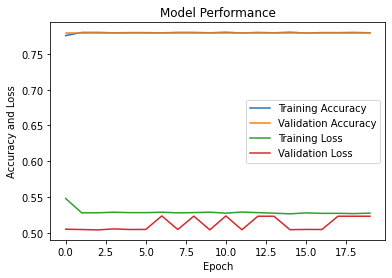

In [54]:
# run the test harness for evaluating a model
def run_test_harness():
	# create data generator
	datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,zoom_range=0.1)
	# prepare iterator
	it_train = datagen.flow(data_new[:100], y_train_labels_np[:100], batch_size=64)
	# fit model
	steps = int(data_new.shape[0] / 64)
	hist = model_vgg.fit_generator(it_train, steps_per_epoch=steps, epochs=20, validation_data=(data_new_X_val[:100], y_val_labels_np[:100]), verbose=1, callbacks = callback_vgg)
	# evaluate model
	_, acc = model_vgg.evaluate(data_new_X_val[:100], y_val_labels_np[:100], verbose=1)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(hist)

# entry point, run the test harness
run_test_harness()

In [ ]:
# hist = model_vgg.fit(data_new,y_train_labels_np, batch_size=64, epochs=500, validation_data=(data_new_X_val, y_val_labels_np), verbose=1, callbacks = callback_vgg)

In [ ]:
# summarize_diagnostics(hist)